# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count, when, isnan 
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import  LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# from pyspark.mllib.classification import LogisticRegressionWithSGD
# from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from pyspark.sql import Window
from pyspark.sql.functions import sum as Fsum
import pyspark.sql.functions as F
import re
from functools import reduce

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Working with sparkify") \
    .getOrCreate()

/home/rohit/anaconda3/envs/EEG/lib/python3.6/site-packages/pyspark/context.py:238: FutureWarning: Python 3.6 support is deprecated in Spark 3.2.
  FutureWarning


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'

In [4]:
user_log = spark.read.json(sparkify_data)

In [5]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
shape_user_log=user_log.count()

In [7]:
user_log.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

## Things to do in this section:
- Check nan values
- Check null values
- Check blank values in userID
- decide what to do with the missing values

In [8]:
# count nan/ missing values for every column in the table
user_log.select([count(when(isnan(c), c)).alias(c) for c in user_log.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



**There seems to be no nan or missing values, so for now it seems like no rows need to be eliminated and can be useful for churn prediction. But there is a possibility that even though there are no nan values, there might be None or empty values present for important columns that might make the whole row non usable for churn prediction.**

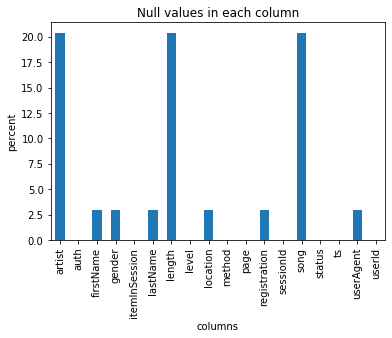

In [9]:
# count null values for every column in the table
temp=user_log.select([(count(when(col(c).isNull(), c))/shape_user_log*100).alias(c) for c in user_log.columns]).toPandas().loc[0]
temp.plot.bar(legend=None);
plt.ylabel('percent');
plt.xlabel('columns');
plt.title('Null values in each column');


In [10]:
temp

artist           20.381152
auth              0.000000
firstName         2.913089
gender            2.913089
itemInSession     0.000000
lastName          2.913089
length           20.381152
level             0.000000
location          2.913089
method            0.000000
page              0.000000
registration      2.913089
sessionId         0.000000
song             20.381152
status            0.000000
ts                0.000000
userAgent         2.913089
userId            0.000000
Name: 0, dtype: float64

**We can see a pattern for various columns in terms of null values. The columns 'artist', 'length' and 'song' has 20.38% null values. It seems like these columns gives info about the artists, song length and song that the particular user listens to, but there is less chance that they may help predict whether the user will churn or not. Whereas, columns 'firstName', 'gender', 'lastName', 'location', 'registration' and 'userAgent' has 2.91% null values. And these columns does not seem to be null by mistake, it seeems like these are logs of users who either do not have an account or have logged out on sparkify and are using the free version of the app. In both of the above senario we do not have any solid reason to eliminate these columns, so we will keep them until we have a solid reason.**

In [11]:
user_log.select(['*']).where(user_log.firstName.isNull()).collect()

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=100, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355745000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=101, lastName=None, length=None, level='free', location=None, method='GET', page='Help', registration=None, sessionId=8, song=None, status=200, ts=1538355807000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=102, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355841000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=103, lastName=None, length=None, level='free', location=None, method='PUT', page='Login', registration=None, s

In [12]:
## count empty values for every column in the table
user_log.select([count(when(user_log[c] == "",c)).alias(c) for c in user_log.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [13]:
## count empty values AND null values for every column in the table
user_log.select([count(when((user_log[c] == "") & (col(c).isNull()),c)).alias(c) for c in user_log.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



**In the above two cells we check the empty values in each column, and we found out that only userId has empty values and without the userId we cannot identify the user so, it does not make any sense to keep these rows in the dataframe so we will remove it.**

In [14]:
user_log_valid = user_log.filter(user_log["userId"] != "")
user_log_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [15]:
user_log_valid.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId']

In [16]:
def plot_hist_bar(col):
    temp = user_log_valid.groupby(col).count().orderBy(desc('count')).toPandas()
    if col in ['song','artist']:
        temp = temp[1:]
    print('Number of unique {} are: {}'.format(col,temp.shape[0]))
    print("Frequency of events for {} in descending order:".format(col))
    print(temp)
    temp.hist()
    temp[:20].plot.bar(x=col);
    plt.ylabel('count');
    plt.xlabel(col);
    plt.title('statistics for {} column'.format(col));
    return temp

### Count of log events for each user

Number of unique userId are: 225
Frequency of events for userId in descending order:
     userId  count
0        39   9632
1        92   7230
2       140   6880
3    300011   5732
4       124   4825
..      ...    ...
220  300003     35
221  100011     23
222     125     11
223     135      6
224     156      6

[225 rows x 2 columns]


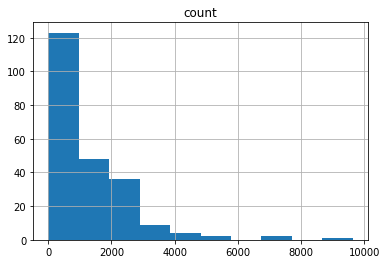

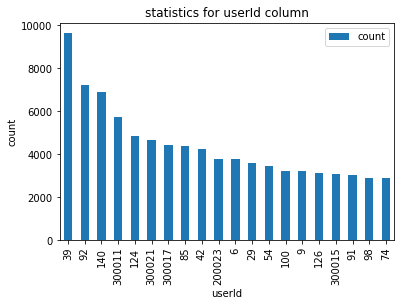

In [17]:
userId_stat = plot_hist_bar('userId')

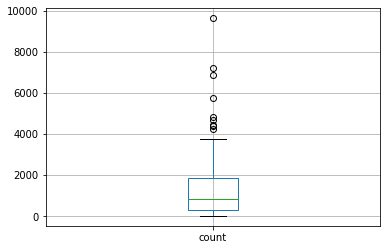

In [18]:
userId_stat.boxplot()

**The above historgram shows that majority of the users have 2k to 3k events on sparkify, and the users with events more then that come in the minority. The bar chart shows the list of top 20 most active users.**

**Note: Here "active" does not mean having most events per day/month etc. It means the user has most events during the entire span of the data, and the results may or maynot change if we check the events per day/week or month.**

Number of unique artist are: 17655
Frequency of events for artist in descending order:
                                          artist  count
1                                  Kings Of Leon   1841
2                                       Coldplay   1813
3                         Florence + The Machine   1236
4                                  Dwight Yoakam   1135
5                                       BjÃÂ¶rk   1133
...                                          ...    ...
17651                             MC Paul Barman      1
17652  The Far East Movement featuring  Jah Free      1
17653                                The Willowz      1
17654                               PROFANE OMEN      1
17655                              So Percussion      1

[17655 rows x 2 columns]


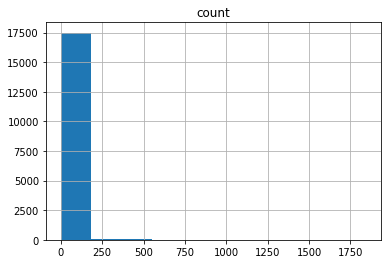

/home/rohit/anaconda3/envs/EEG/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/rohit/anaconda3/envs/EEG/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


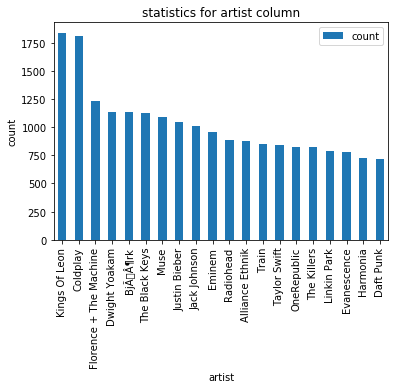

In [19]:
artist_stats = plot_hist_bar('artist')

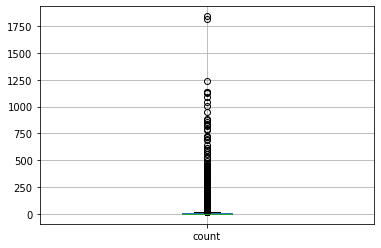

In [20]:
artist_stats.boxplot()

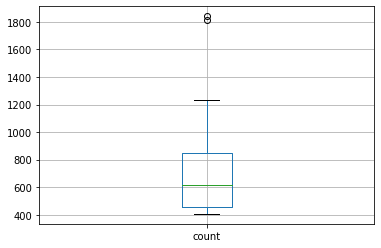

In [21]:
artist_stats[:50].boxplot()

Number of unique song are: 58480
Frequency of events for song in descending order:
                                                    song  count
1                                         You're The One   1153
2                                                   Undo   1026
3                                                Revelry    854
4                                          Sehr kosmisch    728
5      Horn Concerto No. 4 in E flat K495: II. Romanc...    641
...                                                  ...    ...
58476                     Contortionists (Album Version)      1
58477                                Time Has Come Again      1
58478     Left To My Own Devices (2001 Digital Remaster)      1
58479                 Mediterranean Sundance / Rio Ancho      1
58480                              Sugar Hill (Explicit)      1

[58480 rows x 2 columns]


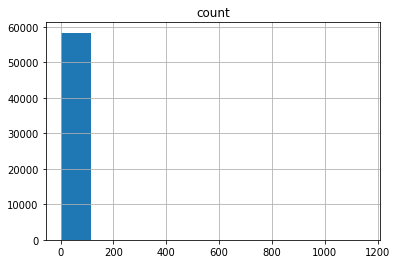

/home/rohit/anaconda3/envs/EEG/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/rohit/anaconda3/envs/EEG/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 131 missing from current font.
  font.set_text(s, 0, flags=flags)


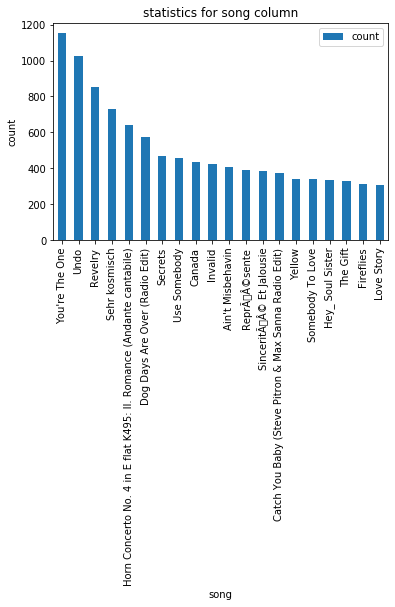

In [22]:
song_stats = plot_hist_bar('song')

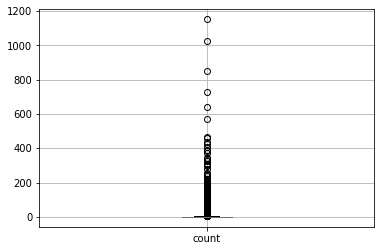

In [23]:
song_stats.boxplot()

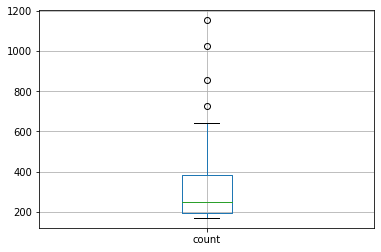

In [24]:
song_stats[:50].boxplot()

Number of unique gender are: 2
Frequency of events for gender in descending order:
  gender   count
0      F  154578
1      M  123576


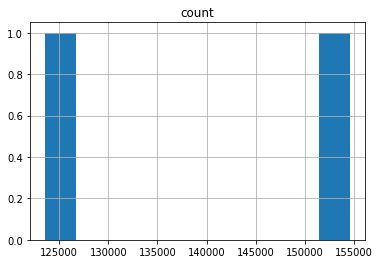

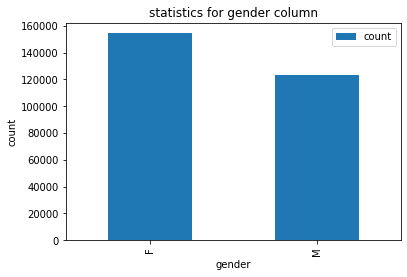

In [25]:
gender_stats = plot_hist_bar('gender')

Number of unique page are: 19
Frequency of events for page in descending order:
                         page   count
0                    NextSong  228108
1                   Thumbs Up   12551
2                        Home   10082
3             Add to Playlist    6526
4                  Add Friend    4277
5                 Roll Advert    3933
6                      Logout    3226
7                 Thumbs Down    2546
8                   Downgrade    2055
9                    Settings    1514
10                       Help    1454
11                    Upgrade     499
12                      About     495
13              Save Settings     310
14                      Error     252
15             Submit Upgrade     159
16           Submit Downgrade      63
17                     Cancel      52
18  Cancellation Confirmation      52


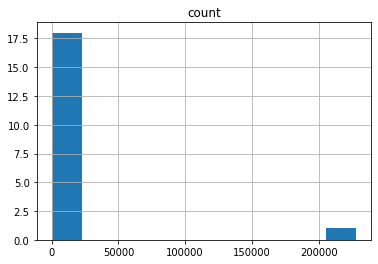

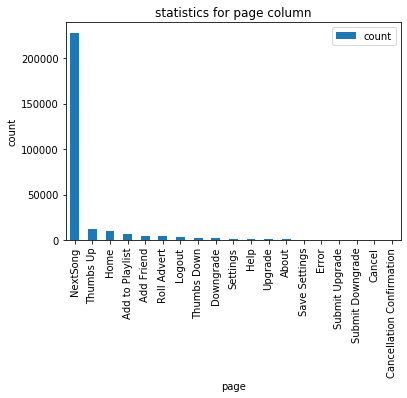

In [26]:
page_stats = plot_hist_bar('page')

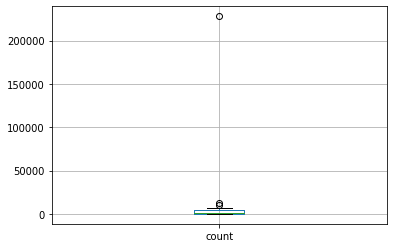

In [27]:
page_stats.boxplot()

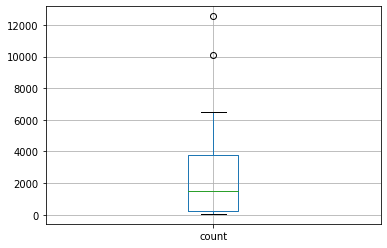

In [28]:
page_stats[1:].boxplot()

### Downgrade vs Downgrade Submit. 

- It seems to me that Downgrading or churning is a two step process, where you land on the 'Downgrade' page when you are considering the option of downgrading(maybe it contains information about downgrading) and 'Submit Downgrade' is the page when you have actually downgraded and you get a confirmation about it.

### Upgrade vs Submit Upgrade.

- Similar logic applies here. Upgrade page is where you are considering upgrading from free to paid level(maybe it consists of information about the paid level and its benefits). And Submit Upgrade is when you actually converge and have taken a decision to actually upgrade.

It would be interesting to see the ratio of 'Downgrade' to 'Submit Downgrade' and 'Upgrade' to 'Submit Upgrade' as it will tell us how many people actually churn or converge after considering the options.

In [29]:
churn_ratio = page_stats[page_stats['page'] == 'Submit Downgrade']['count'].item()/page_stats[page_stats['page'] == 'Downgrade']['count'].item()

In [30]:
convergance_ratio = page_stats[page_stats['page'] == 'Submit Upgrade']['count'].item()/page_stats[page_stats['page'] == 'Upgrade']['count'].item()

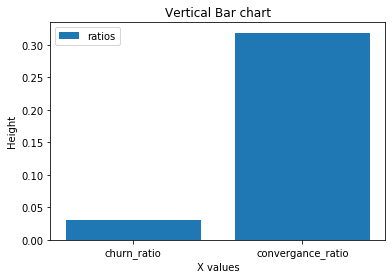

In [31]:
plt.bar(['churn_ratio','convergance_ratio'],[churn_ratio,convergance_ratio], label="ratios")
plt.legend()

# The following commands add labels to our figure.
plt.xlabel('X values')
plt.ylabel('Height')
plt.title('Vertical Bar chart')

plt.show()

Number of unique userAgent are: 56
Frequency of events for userAgent in descending order:
                                            userAgent  count
0   "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...  22751
1   "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...  19611
2   "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...  18448
3   "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...  17348
4   Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...  16700
5   "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...  15395
6   "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...  14598
7   Mozilla/5.0 (Macintosh; Intel Mac OS X 10.9; r...  10300
8   "Mozilla/5.0 (iPad; CPU OS 7_1_2 like Mac OS X...   8912
9   Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...   8624
10  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...   8094
11  "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537....   7923
12  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...   7906
13  "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...   

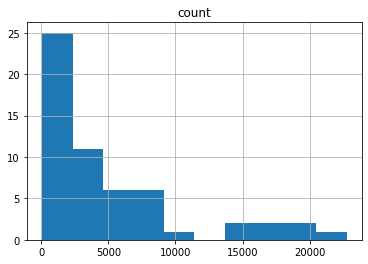

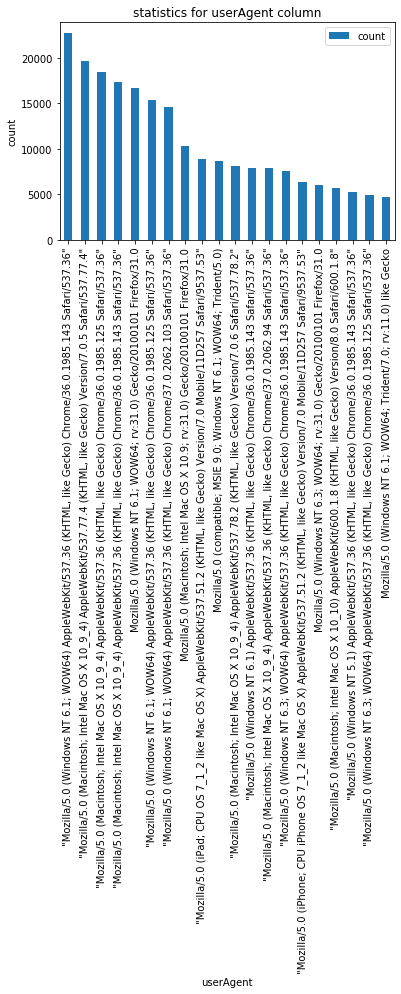

In [32]:
userAgent_stats = plot_hist_bar('userAgent')

The userAgent has a conventional format like this: ```Mozilla/5.0 (<system-information>) <platform> (<platform-details>) <extensions>```
 We can better organize the content and push out better graphs if we seperately look at system information and extension. 

In [33]:
get_sys_info = udf(lambda x: x.split(';')[0].split('(')[1].split(') ')[0])

In [34]:
user_log_valid = user_log_valid.withColumn("sys-info", get_sys_info(user_log_valid.userAgent))

In [35]:
get_uA_extension = udf(lambda x: x.split(' ')[-1])
user_log_valid = user_log_valid.withColumn("uA-extension", get_uA_extension(user_log_valid.userAgent))

In [36]:
user_log_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', sys-info='Windows NT 6.1', uA-extension='Firefox/31.0')

Number of unique sys-info are: 10
Frequency of events for sys-info in descending order:
         sys-info   count
0       Macintosh  102749
1  Windows NT 6.1   99382
2  Windows NT 6.3   18530
3            iPad   11381
4          iPhone   11192
5      compatible   10684
6             X11    8961
7  Windows NT 5.1    7406
8  Windows NT 6.2    5427
9  Windows NT 6.0    2442


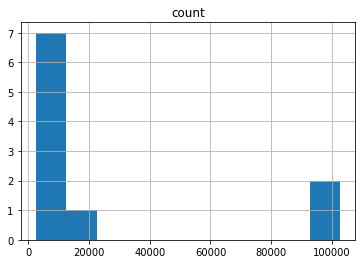

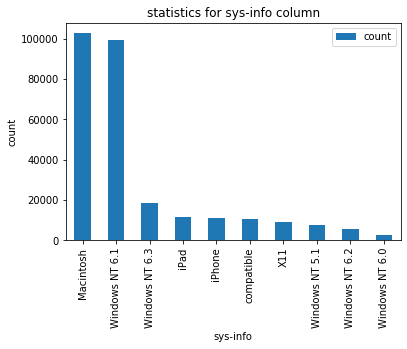

In [37]:
sys_info_stats = plot_hist_bar('sys-info')

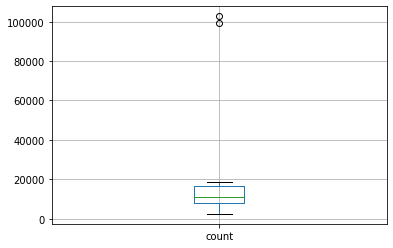

In [38]:
sys_info_stats.boxplot()

Number of unique uA-extension are: 16
Frequency of events for uA-extension in descending order:
         uA-extension   count
0      Safari/537.36"  145591
1        Firefox/31.0   47675
2     Safari/9537.53"   22573
3    Safari/537.77.4"   20184
4        Trident/5.0)    9869
5    Safari/537.78.2"    8094
6     Safari/600.1.8"    5716
7               Gecko    4663
8        Firefox/32.0    3655
9        Firefox/30.0    3214
10   Safari/537.76.4"    2067
11    Safari/600.1.3"    1322
12       Firefox/24.0    1102
13   Safari/537.74.9"    1102
14       Trident/6.0)     815
15  Safari/537.75.14"     512


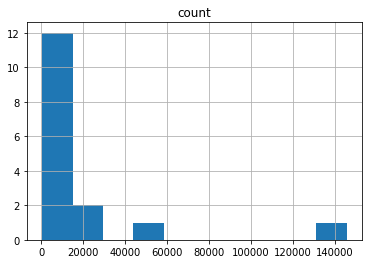

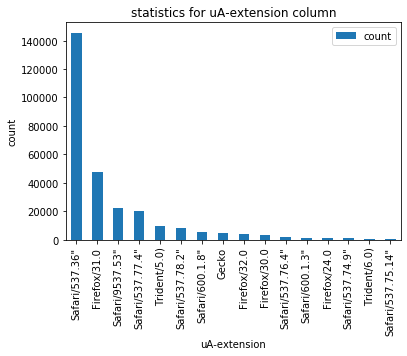

In [39]:
uA_extension_stats = plot_hist_bar('uA-extension')

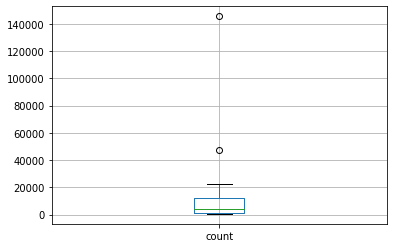

In [40]:
uA_extension_stats.boxplot()

Number of unique auth are: 2
Frequency of events for auth in descending order:
        auth   count
0  Logged In  278102
1  Cancelled      52


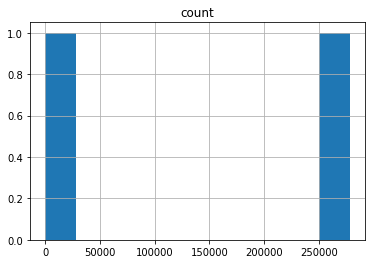

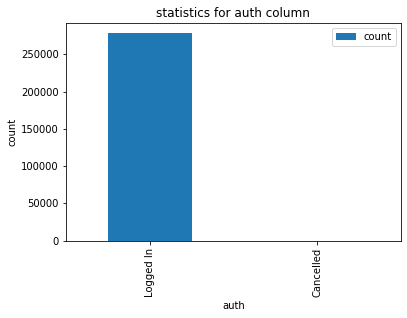

In [41]:
auth_stats = plot_hist_bar('auth')

Number of unique level are: 2
Frequency of events for level in descending order:
  level   count
0  paid  222433
1  free   55721


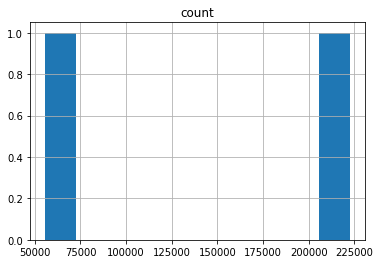

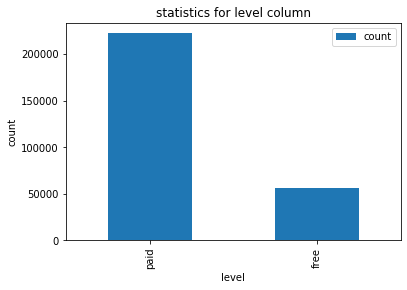

In [42]:
level_stats = plot_hist_bar('level')

In [43]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).day)
user_log_valid = user_log_valid.withColumn("hour", get_hour(user_log_valid.ts))
user_log_valid = user_log_valid.withColumn("day", get_day(user_log_valid.ts))

In [44]:
get_month = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).month)
user_log_valid = user_log_valid.withColumn("month", get_month(user_log_valid.ts))

In [45]:
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))
user_log_valid = user_log_valid.withColumn("weekday", get_weekday(user_log_valid.ts))

Number of unique hour are: 24
Frequency of events for hour in descending order:
   hour  count
0    22  14277
1    21  14157
2    23  13835
3     0  13515
4    20  13382
5     1  13353
6     2  12939
7     3  12478
8    19  12375
9     4  12029
10   18  11585
11    5  11466
12   17  11016
13   16  10862
14    6  10508
15   15  10506
16    7  10086
17    8  10077
18    9  10058
19   14  10028
20   10  10003
21   13   9942
22   11   9899
23   12   9778


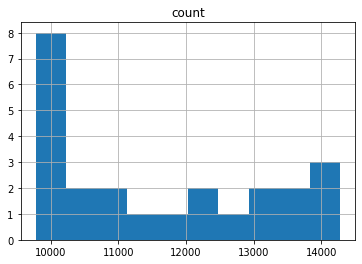

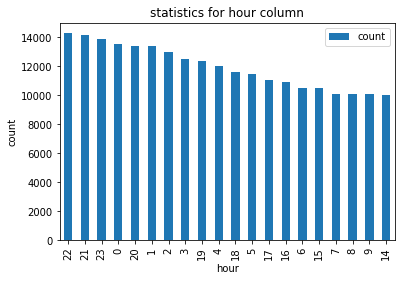

In [46]:
hour_stats = plot_hist_bar('hour')

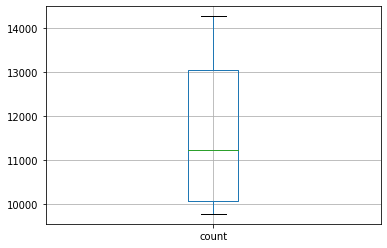

In [47]:
hour_stats.boxplot()

In [48]:
print("On average at any given time there are {} users actively listening on sparkify".format(hour_stats['count'].sum()/hour_stats.shape[0]))

On average at any given time there are 11589.75 users actively listening on sparkify


Number of unique day are: 31
Frequency of events for day in descending order:
   day  count
0    2  11993
1   20  11447
2    9  11373
3   16  11332
4   30  10809
5    1  10351
6   27  10086
7   21   9690
8    3   9486
9   11   9414
10  15   9400
11  10   9319
12  23   9259
13  19   9179
14  26   8896
15  24   8878
16  17   8818
17  12   8588
18  25   8460
19  29   8344
20  13   8236
21   6   8169
22  22   8123
23   5   7972
24   8   7942
25   7   7905
26  28   7774
27  18   7259
28   4   7090
29  14   7052
30  31   5510


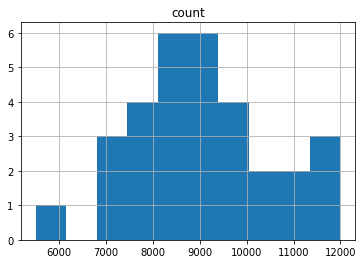

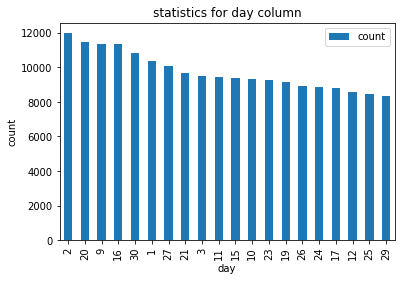

In [49]:
day_stats = plot_hist_bar('day')

In [50]:
print("On average at any given day there are {} users actively listening on sparkify".format(day_stats['count'].sum()/day_stats.shape[0]))

On average at any given day there are 8972.709677419354 users actively listening on sparkify


Number of unique month are: 3
Frequency of events for month in descending order:
  month   count
0    10  143648
1    11  133412
2    12    1094


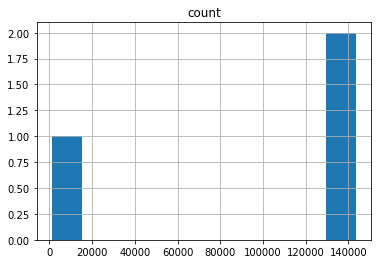

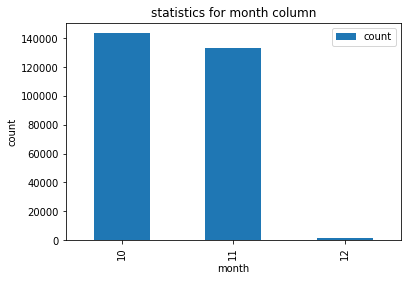

In [51]:
month_stats = plot_hist_bar('month')

Number of unique weekday are: 7
Frequency of events for weekday in descending order:
  weekday  count
0       5  48767
1       3  48609
2       2  45927
3       4  43295
4       1  36100
5       6  32954
6       0  22502


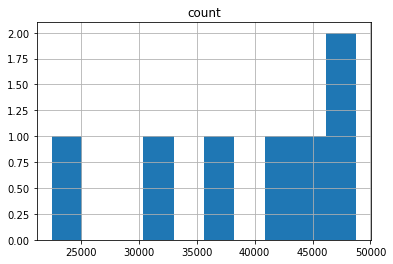

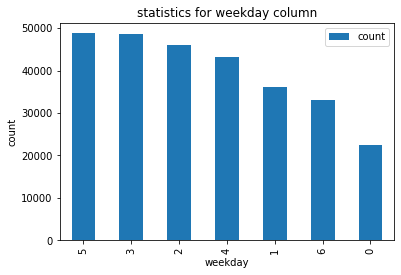

In [52]:
weekday_stats = plot_hist_bar('weekday')

In [53]:
get_loc = udf(lambda x: x.split(',')[1][1:])
user_log_valid = user_log_valid.withColumn("location", get_loc(user_log_valid.location))
user_log_valid.groupby('location').count().collect()

[Row(location='UT-ID', count=317),
 Row(location='AZ', count=4846),
 Row(location='SC', count=668),
 Row(location='GA-AL', count=2716),
 Row(location='LA', count=1171),
 Row(location='RI-MA', count=927),
 Row(location='NJ', count=7001),
 Row(location='IL-MO', count=1003),
 Row(location='MN-WI', count=2241),
 Row(location='OR', count=23),
 Row(location='SC-NC', count=837),
 Row(location='PA-NJ', count=815),
 Row(location='MD-WV', count=982),
 Row(location='VA', count=4651),
 Row(location='NY-NJ-PA', count=23684),
 Row(location='KY', count=3462),
 Row(location='NH', count=4764),
 Row(location='MI', count=7216),
 Row(location='NV', count=2042),
 Row(location='WI', count=1342),
 Row(location='CA', count=46771),
 Row(location='CT', count=6720),
 Row(location='MT', count=2386),
 Row(location='NC', count=10688),
 Row(location='MD', count=2710),
 Row(location='NE-IA', count=187),
 Row(location='IL', count=2102),
 Row(location='WA', count=3772),
 Row(location='MS', count=4634),
 Row(location='A

Number of unique location are: 58
Frequency of events for location in descending order:
       location  count
0            CA  46771
1      NY-NJ-PA  23684
2            TX  23494
3         MA-NH  13873
4            FL  13190
5            NC  10688
6         NC-SC   7780
7            CO   7493
8            MI   7216
9            NJ   7001
10        KY-IN   6880
11           CT   6720
12  PA-NJ-DE-MD   5890
13     IL-IN-WI   5114
14        MO-IL   4858
15           AZ   4846
16           NH   4764
17           VA   4651
18           MS   4634
19           NY   4536
20           GA   4236
21           WA   3772
22           AK   3563
23           KY   3462
24           OH   3432
25  DC-VA-MD-WV   3090
26           PA   2923
27           AL   2857
28        GA-AL   2716
29           MD   2710
30        MO-KS   2562
31           MT   2386
32           WV   2278
33        MN-WI   2241
34           IL   2102
35           NV   2042
36        TN-VA   1863
37           OK   1842
38           TN

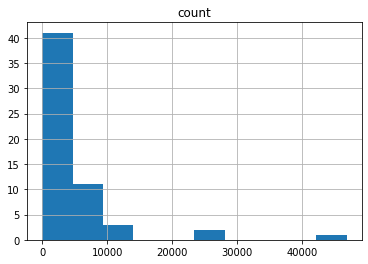

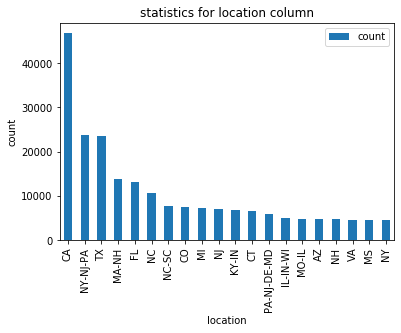

In [54]:
location_stats = plot_hist_bar('location')

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [55]:
# Churn is a label for user who cancelled
# Define a flag function
flag_cancelation = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
# apply to the dataframe
user_log_valid = user_log_valid.withColumn("churn", flag_cancelation("page"))
#Define window bounds
windowval = Window.partitionBy("userId").rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
# Applying the window
user_log_valid = user_log_valid.withColumn("churn", Fsum("churn").over(windowval))

The above code will set the churn column to 1 for the users who have a ```cancellation confirmation``` event in their log. 

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Things to do in this section:

- churn variable should be the focus over here, so all the analysis in this section will be around the churn variable by varying other columns.
- check frequency of events of active users vs churned users.
- Check frequency of unique active users vs churned users.
- check frequency of male and female active vs churned users.
- check frequency of paid and free active bs churned users.
- check frequency of active and churned users at different locations.
- check frequency of page visits of active and churned users.
- check hourly activity of active users vs churned users.
- check day of the month activity of active vs churned users.
- check monthly activity of active vs churned users.
- check week of the day activity of active and churned users.
- focus on the difference in activity of users before and after churning.

In [56]:
# Number of users who churned vs who did not.
user_log_valid.dropDuplicates(['userId']).groupby(['churn']).count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|  173|
|    1|   52|
+-----+-----+



In [57]:
# number of male and female users who churned and who did not

user_log_valid.dropDuplicates(['userId']).groupby(['gender','churn']).count().show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|    0|   84|
|     F|    1|   20|
|     M|    0|   89|
|     M|    1|   32|
+------+-----+-----+



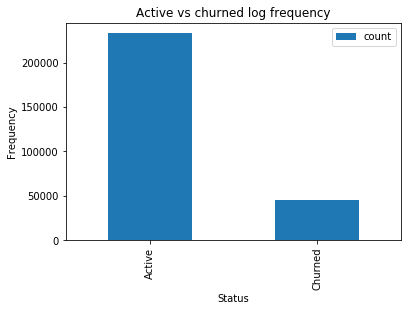

In [58]:
ax = user_log_valid.groupby(['churn']).count().toPandas().plot(kind='bar',title = 'Active vs churned log frequency',x='churn');
ax.set_xlabel('Status');
ax.set_xticklabels(['Active','Churned'])
ax.set_ylabel('Frequency');

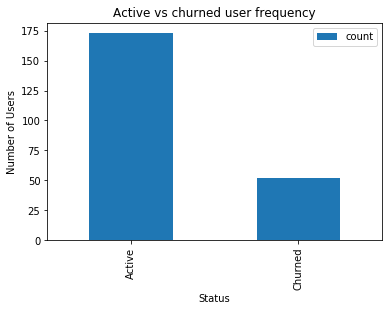

In [59]:
ax = user_log_valid.dropDuplicates(['userId']).groupby(['churn']).count().toPandas().plot(kind='bar',title = 'Active vs churned user frequency',x='churn');
ax.set_xlabel('Status');
ax.set_xticklabels(['Active','Churned'])
ax.set_ylabel('Number of Users');

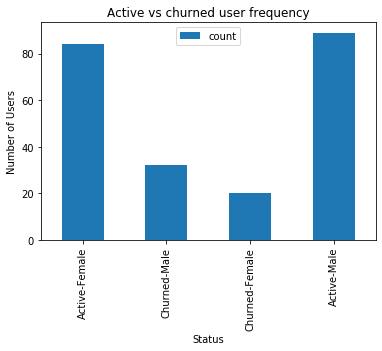

In [60]:
ax = user_log_valid.dropDuplicates(['userId']).groupby(['churn','gender']).count().toPandas().plot(kind='bar',title = 'Active vs churned user frequency',x='churn');
ax.set_xlabel('Status');
ax.set_xticklabels(['Active-Female','Churned-Male','Churned-Female', 'Active-Male'])
ax.set_ylabel('Number of Users');

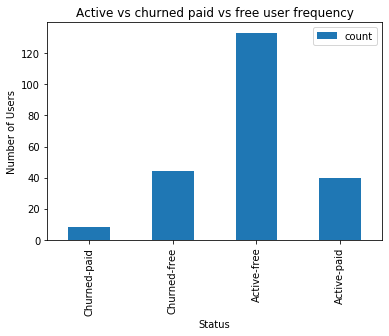

In [61]:
ax = user_log_valid.dropDuplicates(['userId']).groupby(['churn','level']).count().toPandas().plot(kind='bar',title = 'Active vs churned paid vs free user frequency',x='churn');
ax.set_xlabel('Status');
ax.set_xticklabels(['Churned-paid','Churned-free','Active-free', 'Active-paid'])
ax.set_ylabel('Number of Users');

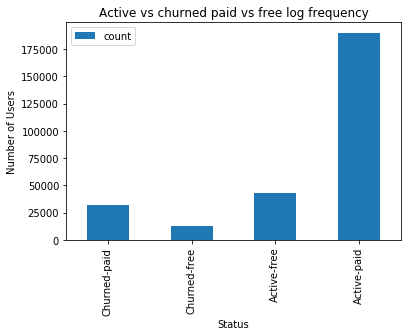

In [62]:
ax = user_log_valid.groupby(['churn','level']).count().toPandas().plot(kind='bar',title = 'Active vs churned paid vs free log frequency',x='churn');
ax.set_xlabel('Status');
ax.set_xticklabels(['Churned-paid','Churned-free','Active-free', 'Active-paid'])
ax.set_ylabel('Number of Users');

In [63]:
def get_normalized(df,col):
    df['count'] = df['count']/df['count'].sum()*100
    if col in ['hour', 'day', 'month', 'weekday']:
        df[col] = df[col].astype(int)
    return df.sort_values(by=col)

In [64]:
def plot_churn_frequency(col, log=True):
    if log==True:
        logs_loc_churned = user_log_valid.where(user_log_valid.churn == 1).groupby(['churn',col]).count().toPandas()
        logs_loc_active = user_log_valid.where(user_log_valid.churn == 0).groupby(['churn',col]).count().toPandas()
        logs_loc_churned = get_normalized(logs_loc_churned,col)
        logs_loc_active = get_normalized(logs_loc_active,col)
    else:
        logs_loc_churned=user_log_valid.dropDuplicates(['userId']).where(user_log_valid.churn == 1).groupby(['churn',col]).count().toPandas()
        logs_loc_active=user_log_valid.dropDuplicates(['userId']).where(user_log_valid.churn == 0).groupby(['churn',col]).count().toPandas()
        logs_loc_churned = get_normalized(logs_loc_churned,col)
        logs_loc_active = get_normalized(logs_loc_active,col)
#     print(logs_loc_churned,logs_loc_active)
    logs_loc = pd.merge(logs_loc_active, logs_loc_churned, on=[col])
#     print(logs_loc)
    logs_loc.columns = ['churn_x', col, 'active', 'churn_x', 'churned']
    if col == 'page':
        logs_loc = logs_loc[logs_loc['page']!='NextSong']
    ax = logs_loc[[col, 'active', 'churned']].plot(kind='bar',x=col,figsize=(10, 5));
    if log == True:
        ax.set_title('Active vs churned {} wise log frequency'.format(col))
    else:
        ax.set_title('Active vs churned {} wise user frequency'.format(col))
    ax.set_xlabel(col);
    # ax.set_xticklabels(['Churned-paid','Churned-free','Active-free', 'Active-paid'])
    ax.set_ylabel('frequency');

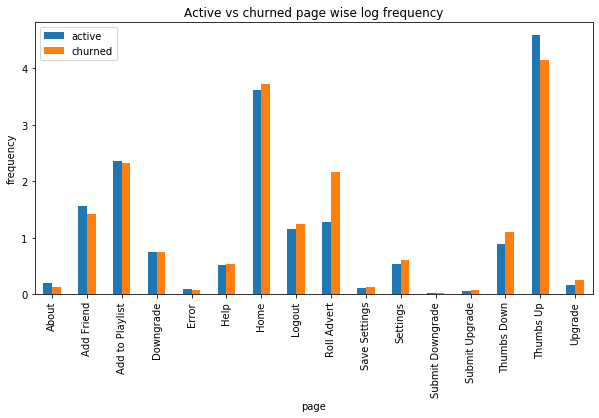

In [65]:
plot_churn_frequency('page')

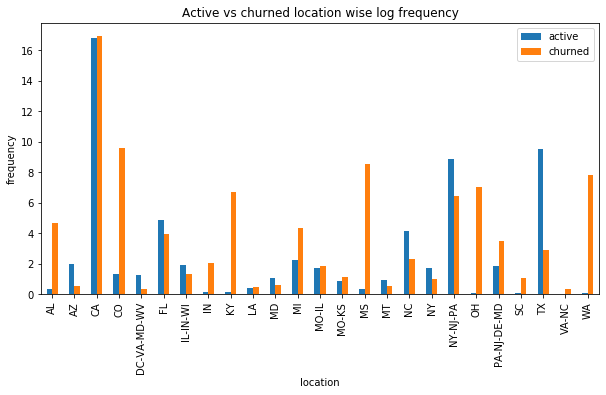

In [66]:
plot_churn_frequency('location')

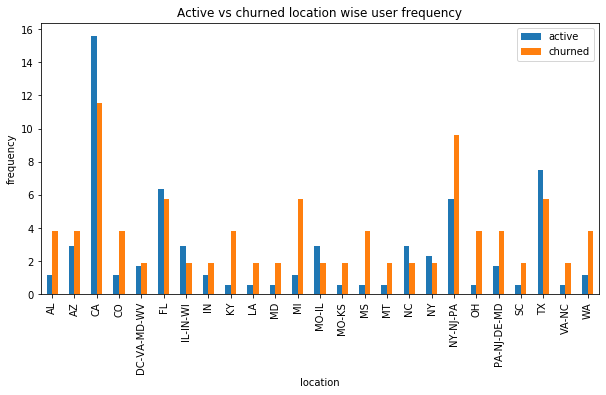

In [67]:
plot_churn_frequency('location',False)

In [68]:
user_log_valid.head()

Row(artist='Sea Wolf', auth='Logged In', firstName='Brycen', gender='M', itemInSession=0, lastName='Bradley', length=265.53424, level='paid', location='MS', method='PUT', page='NextSong', registration=1538159495000, sessionId=9, song='Ses Monuments', status=200, ts=1538965220000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='10', sys-info='Macintosh', uA-extension='Safari/537.36"', hour='7', day='8', month='10', weekday='1', churn=0)

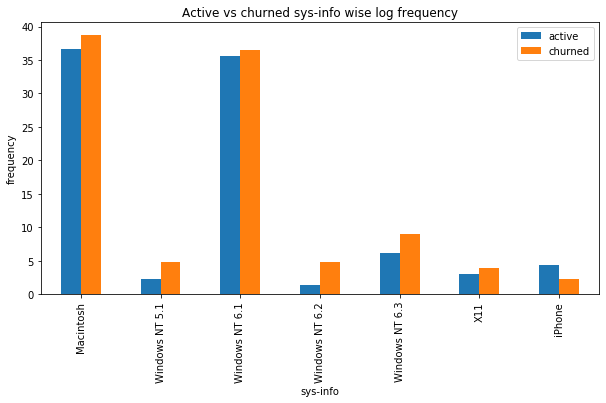

In [69]:
plot_churn_frequency('sys-info')

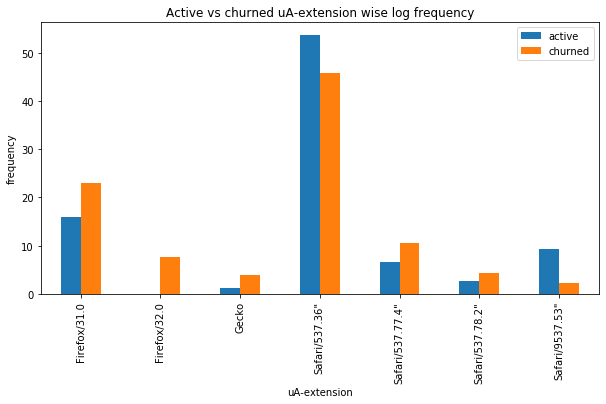

In [70]:
plot_churn_frequency('uA-extension')

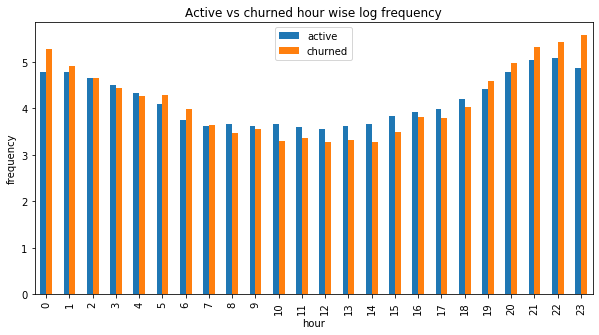

In [71]:
plot_churn_frequency('hour')

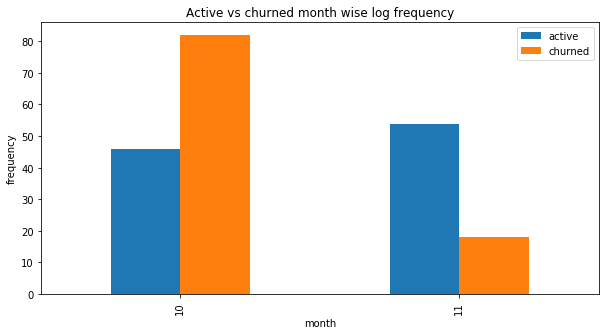

In [72]:
plot_churn_frequency('month')

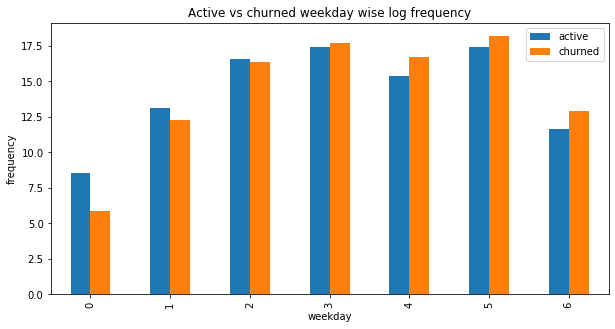

In [73]:
plot_churn_frequency('weekday')

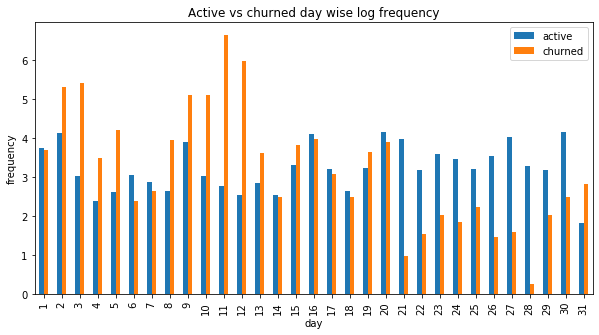

In [74]:
plot_churn_frequency('day')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Features engineering:

- There are two ways in which we can format the data for training.
    - First, do the usual and just convert categorical data to dummy variables and staradize other numerical features and just feed the whole data set into the machine learning model.
    - Second, instead of using all the rows, we can groupby using userId column and calculate clever features which would actually help the model make better decisions. Some of these features that can be calculated for each user are:
        - Song length per user per session
        - Number of ThumbsUp, ThumbsDown, InviteFriends, downgrades, songs per session, artists the user fans
        - Session's duration, count per user
        - The user's subscription age
        - Number of days as free/paid user

### Things to do in this section:
- Convert categorical features into dummy variables
- If time permits try both of the above options otherwise go with the second path.


### Converting categorical variables into dummy variables

In [75]:
# gender M or F to 1 or 0

gender_dv = udf(lambda x: 1 if x == "M" else 0, IntegerType())
# apply to the dataframe
user_log_valid = user_log_valid.withColumn("gender", gender_dv("gender"))

In [76]:
# level paid or free to 1 or 0

level_dv = udf(lambda x: 1 if x == "paid" else 0, IntegerType())
# apply to the dataframe
user_log_valid = user_log_valid.withColumn("level", level_dv("level"))

In [77]:
user_lvl = user_log_valid.select(['userId','level'])
user_gender = user_log_valid.select(['userId','gender'])

In [78]:
user_lvl.dropDuplicates().groupby('userId').count().show()

+------+-----+
|userId|count|
+------+-----+
|200002|    2|
|100010|    1|
|   125|    1|
|     7|    1|
|    51|    1|
|   124|    1|
|    15|    1|
|    54|    2|
|   155|    2|
|100014|    1|
|   132|    2|
|   154|    1|
|   101|    2|
|    11|    2|
|   138|    2|
|300017|    1|
|    69|    2|
|    29|    2|
|100021|    1|
|    42|    2|
+------+-----+
only showing top 20 rows



In [79]:
# converting the sys-info and uA-extension column to dummy variables
# source: https://stackoverflow.com/questions/42805663/e-num-get-dummies-in-pyspark
sys_info = user_log_valid.select("sys-info").distinct().rdd.flatMap(lambda x: x).collect()
uA_extension = user_log_valid.select("uA-extension").distinct().rdd.flatMap(lambda x: x).collect()
sys_expr = [F.when(F.col("sys-info") == sys, 1).otherwise(0).alias("sys_"+ sys) for sys in sys_info]
ext_expr = [F.when(F.col("uA-extension") == ext, 1).otherwise(0).alias("ext_" + ext) for ext in uA_extension]
user_log_valid = user_log_valid.select('*', *sys_expr+ext_expr)

In [160]:
sys_dv = user_log_valid.select('userId',user_log_valid.colRegex("`(sys)+?.+`"))

In [162]:
ext_dv = user_log_valid.select('userId',user_log_valid.colRegex("`(ext)+?.+`"))

In [79]:
user_log_valid.head()

Row(artist='Sea Wolf', auth='Logged In', firstName='Brycen', gender=1, itemInSession=0, lastName='Bradley', length=265.53424, level=1, location='MS', method='PUT', page='NextSong', registration=1538159495000, sessionId=9, song='Ses Monuments', status=200, ts=1538965220000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='10', sys-info='Macintosh', uA-extension='Safari/537.36"', hour='7', day='8', month='10', weekday='1', churn=0, sys_iPad=0, sys_X11=0, sys_Windows NT 6.3=0, sys_iPhone=0, sys_Windows NT 6.2=0, sys_Macintosh=1, sys_Windows NT 5.1=0, sys_compatible=0, sys_Windows NT 6.0=0, sys_Windows NT 6.1=0, ext_Safari/537.75.14"=0, ext_Safari/9537.53"=0, ext_Firefox/24.0=0, ext_Safari/537.77.4"=0, ext_Firefox/31.0=0, ext_Firefox/30.0=0, ext_Gecko=0, ext_Safari/537.36"=1, ext_Safari/600.1.3"=0, ext_Trident/5.0)=0, ext_Safari/537.78.2"=0, ext_Safari/537.76.4"=0, ext_Safari/600.1.8"=0, ext_Trid

In [80]:
user_log_valid = user_log_valid.drop('sys-info')
user_log_valid = user_log_valid.drop('uA-extension')
user_log_valid = user_log_valid.drop('userAgent')

### Engineering some important features from available data:

- Song duration per user per session
- Number of ThumbsUp, ThumbsDown, InviteFriends, downgrades, songs per session, artists the user fans
- Session's duration, count per user
- The user's subscription age


In [91]:
# song duration per user per session
song_duration = user_log_valid.filter(user_log_valid.page=='NextSong').select('userId', 'sessionId', 'length')
song_duration = song_duration.withColumn('duration_hrs', (song_duration.length / 3600))
song_duration = song_duration.groupBy('userId', 'sessionId').sum('duration_hrs')
song_duration = song_duration.groupBy('userId').agg(
                        F.avg('sum(duration_hrs)').alias('mean_hrs'), 
                        F.stddev('sum(duration_hrs)').alias('stdev_hrs')).na.fill(0)

In [107]:
song_duration.show()

+------+------------------+------------------+
|userId|          mean_hrs|         stdev_hrs|
+------+------------------+------------------+
|100010|2.6563848154761907|1.5940891633984364|
|200002|       4.352262775| 3.481087253628621|
|   125|0.5803091944444445|               0.0|
|    51|14.535440077777778|11.600663366034107|
|   124|10.042778698313494| 9.370878101268762|
|     7|1.5092891706349203| 1.737257275656408|
|    54| 5.645594599523808| 6.724163903410203|
|    15| 9.470389004166666| 6.159367750898717|
|   155|  9.20274499537037| 6.528671599395435|
|100014| 3.134420003703703|1.7543652306205215|
|   132| 8.387480969444443| 8.411844077944691|
|   154|1.9129651768518519| 0.856709607905588|
|   101|12.429555963055552| 14.92789006740804|
|    11| 2.772047969444445| 2.754383050218178|
|300017| 4.086552733196721|3.6120139088908414|
|   138| 9.489812643703699|11.718117293713128|
|    29| 6.164359171323531|   8.7578661203911|
|    69|  8.82913659382716| 8.270113865858235|
|100021| 3.20

In [98]:
# number of artists user follows
user_artist_follow = user_log_valid.dropDuplicates(['userId','artist']).select(['userId','artist']).groupby('userId').count().withColumnRenamed("count", "aritst_count")
user_artist_follow.show()

+------+------------+
|userId|aritst_count|
+------+------------+
|100010|         253|
|200002|         340|
|   125|           9|
|    51|        1386|
|   124|        2233|
|     7|         143|
|    15|        1303|
|    54|        1745|
|   155|         644|
|   132|        1300|
|   154|          79|
|100014|         234|
|   101|        1242|
|    11|         535|
|   138|        1333|
|300017|        2071|
|    29|        1805|
|    69|         866|
|100021|         208|
|    42|        2074|
+------+------------+
only showing top 20 rows



In [100]:
# count the number of session for each user
user_num_session = user_log_valid.drop_duplicates(['userId','sessionId']).select(['userId','sessionId']).groupby('userId').count().withColumnRenamed("count", "session_count")
user_num_session.show()

+------+-------------+
|userId|session_count|
+------+-------------+
|100010|            7|
|200002|            6|
|   125|            1|
|    51|           10|
|   124|           29|
|     7|            7|
|    54|           37|
|    15|           15|
|   155|            6|
|100014|            6|
|   132|           16|
|   154|            3|
|   101|           10|
|    11|           16|
|300017|           63|
|   138|           15|
|    29|           34|
|    69|            9|
|100021|            5|
|    42|           47|
+------+-------------+
only showing top 20 rows



In [81]:
page_info = user_log_valid.select("page").distinct().rdd.flatMap(lambda x: x).collect()
page_expr = [F.when(F.col("page") == pg, 1).otherwise(0).alias("page_"+ pg) for pg in page_info]
user_log_valid = user_log_valid.select('*', *page_expr)

In [128]:
# count the number of friends added, thumbs up and down given etc by each user.
# Remove Cancel, cancelation confirmation actions
# The to normalize them as percent to sum all to 100.
# https://stackoverflow.com/questions/47641076/spark-normalize-each-row-of-a-dataframe

# The distribution of pages per user (FILLING NAN with 0)
user_page_norm = user_log_valid.groupby('userId').pivot('page').count().na.fill(0) #.toPandas().head(30)

# Drop Cancel	Cancellation Confirmation columns
user_page_norm = user_page_norm.drop(*['Cancel','Cancellation Confirmation'])

# Normalizing each row to sum to 1

# the columns to be summed
pages_cols = user_page_norm.columns[1:]

# Add a total column
new_df = user_page_norm.withColumn('total', sum(user_page_norm[col] for col in pages_cols))

# Apply normalization per column
for col in pages_cols:
    new_df = new_df.withColumn(f'norm_{col}', new_df[col] / new_df['total'] * 100.)
    
# Remove the total column    
new_df = new_df.drop('total')

# Remove the original columns
new_df = new_df.drop(*pages_cols)

# Rename the normalized columns back
oldColumns = new_df.columns
newColumns = ['userId'] + pages_cols
user_page_norm = reduce(lambda new_df, idx: new_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), new_df)

# Freeup memory
new_df=None

user_page_norm.toPandas().head(10)

userId     About  Add Friend  Add to Playlist  Downgrade     Error  \
0  200002  0.632911    0.843882         1.687764   1.054852  0.000000   
1  100010  0.262467    1.049869         1.837270   0.000000  0.000000   
2     125  0.000000    0.000000         0.000000   0.000000  0.000000   
3      51  0.081235    1.137287         2.112104   0.934200  0.040617   
4     124  0.145078    1.533679         2.445596   0.849741  0.124352   
5       7  0.000000    0.497512         2.487562   0.000000  0.497512   
6      54  0.145560    0.960699         2.096070   1.135371  0.029112   
7      15  0.087796    1.360843         2.589991   1.229148  0.087796   
8     155  0.199601    1.097804         2.395210   1.197605  0.299401   
9     132  0.173611    1.779514         1.649306   0.824653  0.130208   

       Help      Home    Logout   NextSong  Roll Advert  Save Settings  \
0  0.421941  4.219409  1.054852  81.645570     1.476793       0.000000   
1  0.524934  2.887139  1.312336  72.178478    13.648294       0.000000   
2  0.000000  0.000000  0.000000  88.888889    11.111111       0.000000   
3  0.487409  3.046304  0.974817  85.743298     0.000000       0.040617   
4  0.476684  3.647668  1.222798  84.538860     0.082902       0.124352   
5  0.497512  4.975124  1.492537  74.626866     7.960199       0.497512   
6  0.494905  3.755459  1.048035  82.707424     1.368268       0.087336   
7  0.351185  4.082529  1.185250  84.021071     0.043898       0.087796   
8  0.898204  2.994012  1.397206  81.836327     0.798403       0.000000   
9  0.694444  3.602431  1.475694  83.680556     0.086806       0.173611   

   Settings  Submit Downgrade  Submit Upgrade  Thumbs Down  Thumbs Up  \
0  0.632911          0.000000        0.210970     1.265823   4.430380   
1  0.000000          0.000000        0.000000     1.312336   4.461942   
2  0.000000          0.000000        0.000000     0.000000   0.000000   
3  0.487409          0.000000        0.000000     0.852965   4.061738   
4  0.414508          0.000000        0.000000     0.849741   3.544041   
5  1.492537          0.000000        0.000000     0.497512   3.482587   
6  0.494905          0.029112        0.029112     0.844250   4.745269   
7  0.702371          0.000000        0.000000     0.614574   3.555751   
8  0.499002          0.000000        0.099800     0.299401   5.788423   
9  0.737847          0.000000        0.043403     0.737847   4.166667   

    Upgrade  
0  0.421941  
1  0.524934  
2  0.000000  
3  0.000000  
4  0.000000  
5  0.995025  
6  0.029112  
7  0.000000  
8  0.199601  
9  0.043403

In [129]:
# song count per user per session
song_count = user_log_valid.filter(user_log_valid.page=='NextSong').select('userId', 'sessionId')
song_count = song_count.groupBy('userId', 'sessionId').count()
song_count = song_count.groupBy('userId').agg(
                        F.avg('count').alias('mean_songs'), 
                        F.stddev('count').alias('stdev_songs'))
song_count = song_count.na.fill(0)

In [130]:
song_count.show()

+------+------------------+------------------+
|userId|        mean_songs|       stdev_songs|
+------+------------------+------------------+
|100010|39.285714285714285| 22.96166577663945|
|200002|              64.5| 51.30984311026492|
|   125|               8.0|               0.0|
|    51|             211.1| 168.1483802413148|
|   124|145.67857142857142|137.40587446912284|
|     7|21.428571428571427|23.859709015109853|
|    54| 81.17142857142858| 98.41104843350422|
|    15|136.71428571428572| 88.69084470262945|
|   155|136.66666666666666| 96.74433661288224|
|100014|42.833333333333336|24.400136611639425|
|   132|             120.5|  119.663973971562|
|   154|              28.0|13.892443989449804|
|   101|             179.7|216.24320156301383|
|    11|           40.4375| 38.78826068112189|
|300017|59.540983606557376| 53.14056008063013|
|   138|             138.0|170.34838252408335|
|    29| 89.05882352941177| 125.9364777772414|
|    69|             125.0|116.83535423834688|
|100021|     

In [134]:
# Day since subscription for every user
def days_since_subscription(user_log_valid, col_name='days_on'):
    # timestamp of users registration
    reg_ts = user_log_valid.select('userId', 'registration').dropDuplicates().withColumnRenamed('registration', 'start')
    # reg_ts.show(5)
    # The maximum timestamp found for the user
    end_ts = user_log_valid.groupBy('userId').max('ts').withColumnRenamed('max(ts)', 'end')
    # end_ts.show(5)
    # The difference
    reg_df = reg_ts.join(end_ts,'userId')
    ticks_per_day = 1000 * 60 * 60 * 24 # as the timestamp is in ticks (0.001 seconds)
    # Merge in one df
    reg_df = reg_df.select('userId', ((reg_df.end-reg_df.start)/ticks_per_day).alias(col_name))
    # reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))
    return reg_df

user_sub_days = days_since_subscription(user_log_valid, col_name='days_total_subscription')
user_sub_days.show(5)

+------+-----------------------+
|userId|days_total_subscription|
+------+-----------------------+
|100010|      55.64365740740741|
|200002|      70.07462962962963|
|   125|      71.31688657407408|
|    51|     19.455844907407407|
|   124|     131.55591435185184|
+------+-----------------------+
only showing top 5 rows



In [144]:
user_song_lvl = user_log_valid.filter(user_log_valid.page=='NextSong').groupBy('userId').pivot('level').count()
user_song_lvl = user_song_lvl.na.fill(0)
active_cols = user_song_lvl.columns[1:]
user_song_lvl = user_song_lvl.withColumn('total', 
                                       sum(user_song_lvl[col] for col in active_cols))
for col in active_cols:
    user_song_lvl = user_song_lvl.withColumn(f'{col}_percent', 
                                           user_song_lvl[col] / user_song_lvl.total * 100)
active_cols.append('total')    
user_song_lvl = user_song_lvl.drop(*active_cols)

user_song_lvl = user_song_lvl.drop('0_percent')
user_song_lvl = user_song_lvl.withColumnRenamed('1_percent','paid_percent')

In [145]:
user_song_lvl.show()

+------+------------------+
|userId|      paid_percent|
+------+------------------+
|200002| 77.51937984496125|
|100010|               0.0|
|   125|               0.0|
|     7|               0.0|
|    51|             100.0|
|   124|             100.0|
|    15|             100.0|
|    54| 84.54769447377683|
|   155|  87.6829268292683|
|100014|             100.0|
|   132| 98.54771784232366|
|   154|               0.0|
|   101| 96.99499165275459|
|    11|29.675425038639876|
|   138| 90.24154589371982|
|300017|             100.0|
|    69| 97.33333333333334|
|    29| 89.66314398943197|
|100021|               0.0|
|    42| 97.22921914357683|
+------+------------------+
only showing top 20 rows



In [188]:
features = [user_gender, sys_dv, ext_dv, song_duration, user_artist_follow, user_num_session, \
           user_page_norm, song_count, user_sub_days, user_song_lvl]

In [189]:
feature_names = ["user_gender", "sys_dv", "ext_dv", "song_duration", "user_artist_follow", "user_num_session", \
           "user_page_norm", "song_count", "user_sub_days", "user_song_lvl"]

In [190]:
# creating the base for the final dataset
final_set = user_log_valid.select(['userId','churn']).dropDuplicates()

In [191]:
for i, feature in enumerate(features):
    print(feature_names[i])
    final_set = final_set.join(feature, 'userId', how='inner').dropDuplicates()
    print (f"the new frame's dimensions is: {final_set.count()} * {len(final_set.columns)}")
final_set = final_set.orderBy('userId', ascending=True)

user_gender
the new frame's dimensions is: 225 * 3
sys_dv
the new frame's dimensions is: 225 * 13
ext_dv
the new frame's dimensions is: 225 * 29
song_duration
the new frame's dimensions is: 225 * 31
user_artist_follow
the new frame's dimensions is: 225 * 32
user_num_session
the new frame's dimensions is: 225 * 33
user_page_norm
the new frame's dimensions is: 225 * 50
song_count
the new frame's dimensions is: 225 * 52
user_sub_days
the new frame's dimensions is: 225 * 53
user_song_lvl
the new frame's dimensions is: 225 * 54


### Saving the whole, less engineered data:

#### Remove the non numeric and non categorical features from the full dataset.

In [83]:
str_type = []
for field in user_log_valid.schema.fields:
    if str(field.dataType) == 'StringType' and field.name != 'userId':
        str_type.append(field.name)
        print(field.name)

artist
auth
firstName
lastName
location
method
page
song
hour
day
month
weekday


In [84]:
user_log_valid = user_log_valid.drop(*str_type)

In [85]:
more_col = ['itemInSession', 'registration', 'sessionId', 'status', 'ts']
user_log_valid= user_log_valid.drop(*more_col)
user_log_valid.head()

Row(gender=1, length=265.53424, level=1, userId='10', churn=0, sys_iPad=0, sys_X11=0, sys_Windows NT 6.3=0, sys_iPhone=0, sys_Windows NT 6.2=0, sys_Macintosh=1, sys_Windows NT 5.1=0, sys_compatible=0, sys_Windows NT 6.0=0, sys_Windows NT 6.1=0, ext_Safari/537.75.14"=0, ext_Safari/9537.53"=0, ext_Firefox/24.0=0, ext_Safari/537.77.4"=0, ext_Firefox/31.0=0, ext_Firefox/30.0=0, ext_Gecko=0, ext_Safari/537.36"=1, ext_Safari/600.1.3"=0, ext_Trident/5.0)=0, ext_Safari/537.78.2"=0, ext_Safari/537.76.4"=0, ext_Safari/600.1.8"=0, ext_Trident/6.0)=0, ext_Firefox/32.0=0, ext_Safari/537.74.9"=0, page_Cancel=0, page_Submit Downgrade=0, page_Thumbs Down=0, page_Home=0, page_Downgrade=0, page_Roll Advert=0, page_Logout=0, page_Save Settings=0, page_Cancellation Confirmation=0, page_About=0, page_Settings=0, page_Add to Playlist=0, page_Add Friend=0, page_NextSong=1, page_Thumbs Up=0, page_Help=0, page_Upgrade=0, page_Error=0, page_Submit Upgrade=0)

In [86]:
user_log_valid.write.save('user_dataset_full.csv', format='csv', header=True)

### Saving the reduced and feature engineered data:

In [192]:
final_set.write.save('user_dataset.csv', format='csv', header=True)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

***
- I will be using to two methods for training the model.
    - First, use all the log events of every user without much feature engineering.
    - Second, use the dataset that we prepared in the previous section, where we grouped the data according to the user and condensed the logs where we end up with one row for each userId.

***

### Things to do in this section:

- Import the previously saved data.
- Remove the spaces between columns for the next task.
- The imported data had string values for every column so we have to convert string value to Integer and Float type.
- Scale the data to bring the distribution of the data with mean = 0 and stdv = 1.
- Split the data into train, validation and test set.
- Train the model for both kinds of data mentioned above.
    - Use crossvalidator.
    - Time the training time of model for both the datasets.
    - Calculate the feature contribution/ importance for both the datasets.
    - report the accuracy, f1-score, precision, recall.

### Some important functions:

In [28]:
def remove_spaces(data):
    '''
    Used to remove space for column names to avoid problems in later stages in spark
    
    INPUT
    data: data
    
    
    OUTPUT
    data
    '''
    for col in final_set.columns:
        data = data.withColumnRenamed(col, col.replace(' ', '_').replace('.', ''))
    print(final_set.columns)
    return data

In [29]:
def convert_to_vec(final_set):
    '''
    Used to vectorize the data as the standard scalar and models in pyspark 
    work on vectorized data
    INPUT
    final_set: data to be vectorized
    
    
    OUTPUT
    vectorized data
    '''
    assembler = VectorAssembler(inputCols=final_set.columns[2:], outputCol='input')
    input_data = assembler.transform(final_set)
    return input_data

In [30]:
def scaling_splitting(input_data):
    '''
    Used to scale the data and split the scaled data into train and test set
    
    INPUT
    input_data: data to be scaled and splited
    
    
    OUTPUT
    train and test data
    '''
    scaler = StandardScaler(inputCol="input", outputCol="scaled_input", withMean=True, withStd=True)
    scalerModel = scaler.fit(input_data)
    scaled_input_data = scalerModel.transform(input_data)
    ml_data = scaled_input_data.select(scaled_input_data.churn.alias('label'), scaled_input_data.scaled_input.alias('features'))
    train, test = ml_data.randomSplit([0.80, 0.20], seed=42)
    return train, test

In [31]:
def train_eval(model,df_train, df_test):
    '''
    Used to train and evaluate a SparkML model based on accuracy and f-1 score
    precisionByLabel, recallByLabel, falsePositiveRateByLabel, truePositiveRateByLabel
    
    INPUT
    model: ML Model to train
    df_train: DataFrame with data
    
    OUTPUT
    None
    '''
    print(f'Training {model}...')
    train_dict = {}
    test_dict = {}
    
    # Instantiating Evaluators
    acc = MulticlassClassificationEvaluator(metricName='accuracy')
    f1 = MulticlassClassificationEvaluator(metricName='f1')
    precision = MulticlassClassificationEvaluator(metricName='precisionByLabel')
    recall = MulticlassClassificationEvaluator(metricName='recallByLabel')
    fpr = MulticlassClassificationEvaluator(metricName='falsePositiveRateByLabel')
    tpr = MulticlassClassificationEvaluator(metricName='truePositiveRateByLabel')
    
    metrics = ['accuracy', 'f1', 'precision', 'recall', 'fpr', 'tpr']
    evaluators = [acc, f1, precision, recall, fpr, tpr]
    
    # Training and predicting with model
    model_fit = model.fit(df_train)
    result_train = model_fit.transform(df_train)
    result_test = model_fit.transform(df_test)
    
    # Calculating metrics
    for num,i in enumerate(metrics):
        train_dict[i] = evaluators[num].evaluate(result_train)
        test_dict[i] = evaluators[num].evaluate(result_test)
    train_df = pd.DataFrame([train_dict])
    test_df = pd.DataFrame([test_dict])
    
    print("train results: ")
    display(train_df)
    print("test results: ")
    display(test_df)

In [32]:
def define_models():
    '''
    Used to define models
    
    INPUT
    None
    OUTPUT
    models
    '''
    # Arbitrarily picked these three algorithms to try
    lr = LogisticRegression(maxIter=30)
    gbt = GBTClassifier()
    rf = RandomForestClassifier()
    return [lr,gbt,rf]

In [33]:
def cross_val(model, paramGrid):
    '''
    Used to define the cross validator
    
    INPUT
    model: ML Model to train
    paramGrid: grid of parameters for the model
    
    OUTPUT
    crossval
    '''
    crossval = CrossValidator(estimator=model,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)
    return crossval

In [34]:
def init_grids():
    '''
    Used to initialize the parameters for the models
    
    INPUT
    
    None
    
    OUTPUT
    parram_grids : grids for the models
    '''
    paramGrid_lr = ParamGridBuilder() \
    .addGrid(models[0].elasticNetParam,[0.0, 0.5]) \
    .addGrid(models[0].regParam, [0.1, 0.01]) \
    .build()

    # Going for a very small grid because of compute time
    paramGrid_gbt = ParamGridBuilder() \
        .addGrid(models[1].maxDepth,[3,5]) \
        .addGrid(models[1].maxBins,[16,32]) \
        .build()

    paramGrid_rdc = ParamGridBuilder().addGrid(models[2].numTrees, [10, 30]).build()

    param_grids = [paramGrid_lr, paramGrid_gbt, paramGrid_rdc]
    return param_grids

In [35]:
def train_crossval(train_data,test_data):
    '''
    Used to train and evaluate a SparkML model based on accuracy and f-1 score
    precisionByLabel, recallByLabel, falsePositiveRateByLabel, truePositiveRateByLabel
    
    INPUT
    train_data: DataFrame with data
    test_data: DataFrame with data
    
    OUTPUT
    None
    '''
    for num, i in enumerate(param_grids):
        cross_val_model = cross_val(models[num],i)
        print("model {}: ".format(models[num]))
        train_eval(cross_val_model, train_data, test_data)

### Working with reduced feature engineered data:

In [12]:
final_set = spark.read.csv('user_dataset.csv', header = True)

final_set.head()

Row(userId='10', churn='0', gender='1', sys_iPad='0', sys_X11='0', sys_Windows NT 6.3='0', sys_iPhone='0', sys_Windows NT 6.2='0', sys_Macintosh='1', sys_Windows NT 5.1='0', sys_compatible='0', sys_Windows NT 6.0='0', sys_Windows NT 6.1='0', ext_Safari/537.75.14"='0', ext_Safari/9537.53"='0', ext_Firefox/24.0='0', ext_Safari/537.77.4"='0', ext_Firefox/31.0='0', ext_Firefox/30.0='0', ext_Gecko='0', ext_Safari/537.36"='1', ext_Safari/600.1.3"='0', ext_Trident/5.0)='0', ext_Safari/537.78.2"='0', ext_Safari/537.76.4"='0', ext_Safari/600.1.8"='0', ext_Trident/6.0)='0', ext_Firefox/32.0='0', ext_Safari/537.74.9"='0', mean_hrs='7.725295023611108', stdev_hrs='8.98565713929025', aritst_count='566', session_count='6', About='0.25157232704402516', Add Friend='1.509433962264151', Add to Playlist='1.1320754716981132', Downgrade='0.8805031446540881', Error='0.0', Help='0.12578616352201258', Home='3.7735849056603774', Logout='1.3836477987421385', NextSong='84.65408805031447', Roll Advert='0.125786163

In [13]:
final_set.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- sys_iPad: string (nullable = true)
 |-- sys_X11: string (nullable = true)
 |-- sys_Windows NT 6.3: string (nullable = true)
 |-- sys_iPhone: string (nullable = true)
 |-- sys_Windows NT 6.2: string (nullable = true)
 |-- sys_Macintosh: string (nullable = true)
 |-- sys_Windows NT 5.1: string (nullable = true)
 |-- sys_compatible: string (nullable = true)
 |-- sys_Windows NT 6.0: string (nullable = true)
 |-- sys_Windows NT 6.1: string (nullable = true)
 |-- ext_Safari/537.75.14": string (nullable = true)
 |-- ext_Safari/9537.53": string (nullable = true)
 |-- ext_Firefox/24.0: string (nullable = true)
 |-- ext_Safari/537.77.4": string (nullable = true)
 |-- ext_Firefox/31.0: string (nullable = true)
 |-- ext_Firefox/30.0: string (nullable = true)
 |-- ext_Gecko: string (nullable = true)
 |-- ext_Safari/537.36": string (nullable = true)
 |-- ext_Safari/600.1.3": str

In [14]:
# Change the column names to strings without spaces
final_set = remove_spaces(final_set)

['userId', 'churn', 'gender', 'sys_iPad', 'sys_X11', 'sys_Windows NT 6.3', 'sys_iPhone', 'sys_Windows NT 6.2', 'sys_Macintosh', 'sys_Windows NT 5.1', 'sys_compatible', 'sys_Windows NT 6.0', 'sys_Windows NT 6.1', 'ext_Safari/537.75.14"', 'ext_Safari/9537.53"', 'ext_Firefox/24.0', 'ext_Safari/537.77.4"', 'ext_Firefox/31.0', 'ext_Firefox/30.0', 'ext_Gecko', 'ext_Safari/537.36"', 'ext_Safari/600.1.3"', 'ext_Trident/5.0)', 'ext_Safari/537.78.2"', 'ext_Safari/537.76.4"', 'ext_Safari/600.1.8"', 'ext_Trident/6.0)', 'ext_Firefox/32.0', 'ext_Safari/537.74.9"', 'mean_hrs', 'stdev_hrs', 'aritst_count', 'session_count', 'About', 'Add Friend', 'Add to Playlist', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade', 'mean_songs', 'stdev_songs', 'days_total_subscription', 'paid_percent']


In [15]:
# convert the values into float.
# Convert all to numbers as the schema shows strings

# All columns from Churn to ext* should be integer types
for col in final_set.columns[:29]:
    final_set = final_set.withColumn(col, final_set[col].cast(IntegerType()))
# All other columns should be float
for col in final_set.columns[29:]:
    final_set = final_set.withColumn(col, final_set[col].cast(FloatType()))

final_set.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- sys_iPad: integer (nullable = true)
 |-- sys_X11: integer (nullable = true)
 |-- sys_Windows_NT_63: integer (nullable = true)
 |-- sys_iPhone: integer (nullable = true)
 |-- sys_Windows_NT_62: integer (nullable = true)
 |-- sys_Macintosh: integer (nullable = true)
 |-- sys_Windows_NT_51: integer (nullable = true)
 |-- sys_compatible: integer (nullable = true)
 |-- sys_Windows_NT_60: integer (nullable = true)
 |-- sys_Windows_NT_61: integer (nullable = true)
 |-- ext_Safari/5377514": integer (nullable = true)
 |-- ext_Safari/953753": integer (nullable = true)
 |-- ext_Firefox/240: integer (nullable = true)
 |-- ext_Safari/537774": integer (nullable = true)
 |-- ext_Firefox/310: integer (nullable = true)
 |-- ext_Firefox/300: integer (nullable = true)
 |-- ext_Gecko: integer (nullable = true)
 |-- ext_Safari/53736": integer (nullable = true)
 |-- ext_Safari/60013"

In [16]:
input_data = convert_to_vec(final_set)

In [19]:
train, test = scaling_splitting(input_data)

In [20]:
models = define_models()

In [21]:
for model in models:
    train_eval(model, train, test)

Training LogisticRegression_44de16cc86e4...
train results: 


accuracy        f1  precision    recall       fpr       tpr
0  0.826316  0.809088   0.840491  0.951389  0.565217  0.951389

test results: 


accuracy       f1  precision    recall  fpr       tpr
0  0.885714  0.87619   0.903226  0.965517  0.5  0.965517

Training GBTClassifier_bb7de22fe859...
train results: 


accuracy   f1  precision  recall  fpr  tpr
0       1.0  1.0        1.0     1.0  0.0  1.0

test results: 


accuracy        f1  precision    recall       fpr       tpr
0  0.771429  0.771429   0.862069  0.862069  0.666667  0.862069

Training RandomForestClassifier_fdefdd2af35b...
train results: 


accuracy        f1  precision    recall       fpr       tpr
0  0.921053  0.916262   0.910828  0.993056  0.304348  0.993056

test results: 


accuracy        f1  precision    recall       fpr       tpr
0  0.828571  0.814286   0.870968  0.931034  0.666667  0.931034

In [26]:
param_grids = init_grids()

In [27]:
train_crossval(train,test)

model LogisticRegression_44de16cc86e4: 
Training CrossValidator_e6c3688992b1...
train results: 


accuracy        f1  precision  recall       fpr  tpr
0  0.763158  0.665779   0.761905     1.0  0.978261  1.0

test results: 


accuracy        f1  precision  recall       fpr  tpr
0  0.857143  0.811791   0.852941     1.0  0.833333  1.0

model GBTClassifier_bb7de22fe859: 
Training CrossValidator_3fc8441ae85f...
train results: 


accuracy        f1  precision    recall       fpr       tpr
0  0.957895  0.956856   0.953333  0.993056  0.152174  0.993056

test results: 


accuracy        f1  precision    recall  fpr       tpr
0  0.714286  0.690476   0.806452  0.862069  1.0  0.862069

model RandomForestClassifier_fdefdd2af35b: 
Training CrossValidator_0925cdaba15f...
train results: 


accuracy        f1  precision    recall       fpr       tpr
0  0.910526  0.904026   0.899371  0.993056  0.347826  0.993056

test results: 


accuracy        f1  precision    recall       fpr       tpr
0  0.828571  0.814286   0.870968  0.931034  0.666667  0.931034

In [56]:
## I tried to work with RDD based dataset but it did not have cross validation function in it.
## https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html
## https://stackoverflow.com/questions/47912338/typeerror-data-should-be-an-rdd-of-labeledpoint-but-got-type-numpy-ndarray
## https://stackoverflow.com/questions/51099488/create-labeledpoints-from-a-spark-dataframe-using-pyspark
# from pyspark.mllib.regression import LabeledPoint
# train_rdd = train.rdd.map(lambda row: LabeledPoint(row['churn'], row['scaled_input'].toArray()))
# test_rdd = test.rdd.map(lambda row: LabeledPoint(row['churn'], row['scaled_input'].toArray()))
# model = LogisticRegressionWithSGD.train(train_rdd)

### Working with full dataset:

In [93]:
final_set = spark.read.csv('user_dataset_full.csv', header = True)

final_set.head()

Row(gender='1', length='265.53424', level='1', userId='10', churn='0', sys_iPad='0', sys_X11='0', sys_Windows NT 6.3='0', sys_iPhone='0', sys_Windows NT 6.2='0', sys_Macintosh='1', sys_Windows NT 5.1='0', sys_compatible='0', sys_Windows NT 6.0='0', sys_Windows NT 6.1='0', ext_Safari/537.75.14"='0', ext_Safari/9537.53"='0', ext_Firefox/24.0='0', ext_Safari/537.77.4"='0', ext_Firefox/31.0='0', ext_Firefox/30.0='0', ext_Gecko='0', ext_Safari/537.36"='1', ext_Safari/600.1.3"='0', ext_Trident/5.0)='0', ext_Safari/537.78.2"='0', ext_Safari/537.76.4"='0', ext_Safari/600.1.8"='0', ext_Trident/6.0)='0', ext_Firefox/32.0='0', ext_Safari/537.74.9"='0', page_Cancel='0', page_Submit Downgrade='0', page_Thumbs Down='0', page_Home='0', page_Downgrade='0', page_Roll Advert='0', page_Logout='0', page_Save Settings='0', page_Cancellation Confirmation='0', page_About='0', page_Settings='0', page_Add to Playlist='0', page_Add Friend='0', page_NextSong='1', page_Thumbs Up='0', page_Help='0', page_Upgrade='

In [94]:
final_set.printSchema()

root
 |-- gender: string (nullable = true)
 |-- length: string (nullable = true)
 |-- level: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: string (nullable = true)
 |-- sys_iPad: string (nullable = true)
 |-- sys_X11: string (nullable = true)
 |-- sys_Windows NT 6.3: string (nullable = true)
 |-- sys_iPhone: string (nullable = true)
 |-- sys_Windows NT 6.2: string (nullable = true)
 |-- sys_Macintosh: string (nullable = true)
 |-- sys_Windows NT 5.1: string (nullable = true)
 |-- sys_compatible: string (nullable = true)
 |-- sys_Windows NT 6.0: string (nullable = true)
 |-- sys_Windows NT 6.1: string (nullable = true)
 |-- ext_Safari/537.75.14": string (nullable = true)
 |-- ext_Safari/9537.53": string (nullable = true)
 |-- ext_Firefox/24.0: string (nullable = true)
 |-- ext_Safari/537.77.4": string (nullable = true)
 |-- ext_Firefox/31.0: string (nullable = true)
 |-- ext_Firefox/30.0: string (nullable = true)
 |-- ext_Gecko: string (nullable = true)
 |--

In [95]:
final_set = remove_spaces(final_set)

['gender', 'length', 'level', 'userId', 'churn', 'sys_iPad', 'sys_X11', 'sys_Windows NT 6.3', 'sys_iPhone', 'sys_Windows NT 6.2', 'sys_Macintosh', 'sys_Windows NT 5.1', 'sys_compatible', 'sys_Windows NT 6.0', 'sys_Windows NT 6.1', 'ext_Safari/537.75.14"', 'ext_Safari/9537.53"', 'ext_Firefox/24.0', 'ext_Safari/537.77.4"', 'ext_Firefox/31.0', 'ext_Firefox/30.0', 'ext_Gecko', 'ext_Safari/537.36"', 'ext_Safari/600.1.3"', 'ext_Trident/5.0)', 'ext_Safari/537.78.2"', 'ext_Safari/537.76.4"', 'ext_Safari/600.1.8"', 'ext_Trident/6.0)', 'ext_Firefox/32.0', 'ext_Safari/537.74.9"', 'page_Cancel', 'page_Submit Downgrade', 'page_Thumbs Down', 'page_Home', 'page_Downgrade', 'page_Roll Advert', 'page_Logout', 'page_Save Settings', 'page_Cancellation Confirmation', 'page_About', 'page_Settings', 'page_Add to Playlist', 'page_Add Friend', 'page_NextSong', 'page_Thumbs Up', 'page_Help', 'page_Upgrade', 'page_Error', 'page_Submit Upgrade']


In [96]:
# convert the values into integer.
# Convert all to numbers as the schema shows strings

# All columns should be integer types
for col in final_set.columns[:]:
    final_set = final_set.withColumn(col, final_set[col].cast(IntegerType()))

final_set.printSchema()

root
 |-- gender: integer (nullable = true)
 |-- length: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- sys_iPad: integer (nullable = true)
 |-- sys_X11: integer (nullable = true)
 |-- sys_Windows_NT_63: integer (nullable = true)
 |-- sys_iPhone: integer (nullable = true)
 |-- sys_Windows_NT_62: integer (nullable = true)
 |-- sys_Macintosh: integer (nullable = true)
 |-- sys_Windows_NT_51: integer (nullable = true)
 |-- sys_compatible: integer (nullable = true)
 |-- sys_Windows_NT_60: integer (nullable = true)
 |-- sys_Windows_NT_61: integer (nullable = true)
 |-- ext_Safari/5377514": integer (nullable = true)
 |-- ext_Safari/953753": integer (nullable = true)
 |-- ext_Firefox/240: integer (nullable = true)
 |-- ext_Safari/537774": integer (nullable = true)
 |-- ext_Firefox/310: integer (nullable = true)
 |-- ext_Firefox/300: integer (nullable = true)
 |-- ext_Gecko: integer (nullable = t

In [100]:
cols = final_set.columns[5:]

In [101]:
# rearrage the order of the columns for simplicity
final_set = final_set.select('userId', 'churn', 'level', 'gender', 'length', *cols)

In [106]:
final_set = final_set.na.fill(0)

In [107]:
input_data = convert_to_vec(final_set)

In [108]:
train, test = scaling_splitting(input_data)

In [109]:
models = define_models()

In [114]:
for model in models:
    train_eval(model)

Training LogisticRegression_86ab08f282ac...
train results: 


accuracy        f1  precision    recall       fpr       tpr
0  0.859995  0.815378   0.858796  0.996834  0.847986  0.996834

test results: 


accuracy        f1  precision    recall       fpr       tpr
0  0.862595  0.818745   0.861705  0.996653  0.848773  0.996653

Training GBTClassifier_17de34dcfaff...
train results: 


accuracy       f1  precision    recall       fpr       tpr
0  0.888053  0.87372   0.897843  0.977653  0.575521  0.977653

test results: 


accuracy        f1  precision    recall       fpr       tpr
0  0.889804  0.875695   0.899957  0.977725  0.576745  0.977725

Training RandomForestClassifier_a7b7b48297b9...
train results: 


accuracy        f1  precision    recall       fpr       tpr
0  0.851636  0.796111   0.850131  0.999088  0.911251  0.999088

test results: 


accuracy       f1  precision    recall       fpr       tpr
0  0.854453  0.79979   0.853148  0.998977  0.912453  0.998977

# Conclusion:

In this project, we worked with pyspark to understand, analyze and model data which is much bigger then the memory available on a single machine. I worked on only the subset of the data and hence was able to work in local mode. But all the concepts of pyspark have been properly implemented and put to use as it would have been done in standalone or YARN mode.

After the modeling process with the two types of data, it can be observed that proper feature engineering can save us lot of space, time and computational power. And along with that models trained on the proper feature engineered data works much better then the full dataset. This shows that the amount of data might be important but the quality of the features are much more valuable.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.